### Librerías

In [4]:
# Librerías generales

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2


In [6]:
data_folder_name = 'dl-itba-cifar-100-2024-q-1'

def getFileNames(folder_name):
    
    path = os.path.join(os.getcwd(),'..','..',folder_name)
    file_names = os.listdir(path)

    return file_names 

print(getFileNames(data_folder_name))

['coarse_label_names.pck', 'fine_label_names.pck', 'x_test.npy', 'x_train.npy', 'y_train_coarse.npy', 'y_train_fine.npy']


In [8]:
file_names = getFileNames(data_folder_name)

# Lectura de archivos '.npy' 

x_test = np.load('../'+'../'+data_folder_name+'/'+file_names[2])
x_train = np.load('../'+'../'+data_folder_name+'/'+file_names[3])
y_train_coarse = np.load('../'+'../'+data_folder_name+'/'+file_names[4])
y_train_fine = np.load('../'+'../'+data_folder_name+'/'+file_names[5])

# Lectura de archivos '.pck'

with open('../'+'../'+data_folder_name+'/'+file_names[0], "rb") as f:
    coarse_label_names = pickle.load(f)
f.close()

with open('../'+'../'+data_folder_name+'/'+file_names[1], "rb") as f:
    fine_label_names = pickle.load(f)
f.close()

print('Dimensiones de los datos:')
print(x_test.shape)
print(x_train.shape)
print(y_train_coarse.shape)
print(y_train_fine.shape)

print('Cantidad de clases:')
print(np.shape(coarse_label_names))
print(np.shape(fine_label_names))


Dimensiones de los datos:
(10000, 32, 32, 3)
(50000, 32, 32, 3)
(50000,)
(50000,)
Cantidad de clases:
(20,)
(100,)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

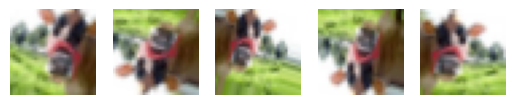

In [12]:
# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load the original image
img = x_train[0]

# Reshape the image to a 4D tensor with shape (1, height, width, channels)
img = img.reshape((1,) + img.shape)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(img, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 5:
        break  # Stop the loop after generating 5 augmented images

for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.uint8(img))
    plt.axis('off')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

### Lectura de datos utilizados para el entrenamiento del modelo

In [14]:
print(f'Dimensiones de x_train: {x_train.shape}')
print(f'Dimensiones de y_train_fine: {y_train_fine.shape}')
print(f'Dimensiones de y_train_coarse: {y_train_coarse.shape}')
print(f'Dimensiones de labels_fine: {len(fine_label_names)}')
print(f'Dimensiones de labels_coarse: {len(coarse_label_names)}')

Dimensiones de x_train: (50000, 32, 32, 3)
Dimensiones de y_train_fine: (50000,)
Dimensiones de y_train_coarse: (50000,)
Dimensiones de labels_fine: 100
Dimensiones de labels_coarse: 20


In [15]:
y_train_union = np.array([[i,j] for i,j in zip(y_train_fine, y_train_coarse)])
print(y_train_union.shape)

(50000, 2)


In [16]:
uniongonza = np.vstack([y_train_fine, y_train_coarse]).T
print(uniongonza.shape)

(50000, 2)


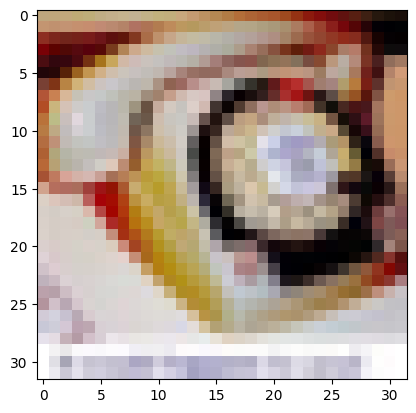

86
telephone
5
household_electrical_devices


In [17]:
num = 5

img = x_train[num]
plt.imshow(img)
plt.show()
print(y_train_union[num][0])
print(fine_label_names[y_train_union[num][0]])
print(y_train_union[num][1])
print(coarse_label_names[y_train_union[num][1]])

In [20]:
x_train_own, x_val_own, y_train_own, y_val_own = train_test_split(x_train, y_train_union, test_size=0.2, stratify=y_train_union)

In [21]:
# prompt: I want to check correct stratification of data (stratification means same proportion of classes in train and validation data)

print(f'Shape of x_train_own: {x_train_own.shape}')
print(f'Shape of x_val_own: {x_val_own.shape}')
print(f'Shape of y_train_own: {y_train_own.shape}')
print(f'Shape of y_val_own: {y_val_own.shape}')

# Check class proportions in the original training data
unique_classes, class_counts = np.unique(y_train_union, axis=0, return_counts=True)
total_samples = len(y_train_union)
original_proportions = class_counts / total_samples

# Check class proportions in the training split
unique_train_classes, train_class_counts = np.unique(y_train_own, axis=0, return_counts=True)
train_total_samples = len(y_train_own)
train_proportions = train_class_counts / train_total_samples


# Check class proportions in the validation split
unique_val_classes, val_class_counts = np.unique(y_val_own, axis=0, return_counts=True)
val_total_samples = len(y_val_own)
val_proportions = val_class_counts / val_total_samples

print("Original Proportions:")
for i in range(len(unique_classes)):
    print(f"Class {unique_classes[i]}: {original_proportions[i]}")

print("\nTrain Proportions:")
for i in range(len(unique_train_classes)):
  print(f"Class {unique_train_classes[i]}: {train_proportions[i]}")


print("\nValidation Proportions:")
for i in range(len(unique_val_classes)):
  print(f"Class {unique_val_classes[i]}: {val_proportions[i]}")

Shape of x_train_own: (40000, 32, 32, 3)
Shape of x_val_own: (10000, 32, 32, 3)
Shape of y_train_own: (40000, 2)
Shape of y_val_own: (10000, 2)
Original Proportions:
Class [0 4]: 0.01
Class [1 1]: 0.01
Class [ 2 14]: 0.01
Class [3 8]: 0.01
Class [4 0]: 0.01
Class [5 6]: 0.01
Class [6 7]: 0.01
Class [7 7]: 0.01
Class [ 8 18]: 0.01
Class [9 3]: 0.01
Class [10  3]: 0.01
Class [11 14]: 0.01
Class [12  9]: 0.01
Class [13 18]: 0.01
Class [14  7]: 0.01
Class [15 11]: 0.01
Class [16  3]: 0.01
Class [17  9]: 0.01
Class [18  7]: 0.01
Class [19 11]: 0.01
Class [20  6]: 0.01
Class [21 11]: 0.01
Class [22  5]: 0.01
Class [23 10]: 0.01
Class [24  7]: 0.01
Class [25  6]: 0.01
Class [26 13]: 0.01
Class [27 15]: 0.01
Class [28  3]: 0.01
Class [29 15]: 0.01
Class [30  0]: 0.01
Class [31 11]: 0.01
Class [32  1]: 0.01
Class [33 10]: 0.01
Class [34 12]: 0.01
Class [35 14]: 0.01
Class [36 16]: 0.01
Class [37  9]: 0.01
Class [38 11]: 0.01
Class [39  5]: 0.01
Class [40  5]: 0.01
Class [41 19]: 0.01
Class [42 

In [22]:
print(f'Dimensiones de x_train_own: {x_train_own.shape}')
print(f'Dimensiones de y_train_own: {y_train_own.shape}')

Dimensiones de x_train_own: (40000, 32, 32, 3)
Dimensiones de y_train_own: (40000, 2)


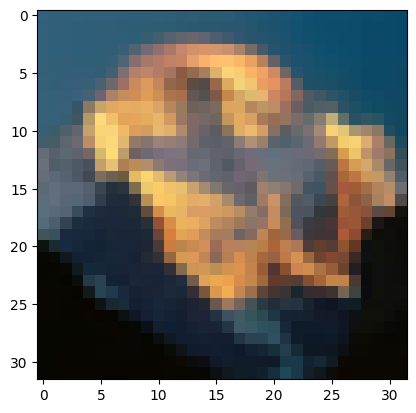

49
mountain
10
large_natural_outdoor_scenes


In [24]:
num2 = 5

img_selected = x_train_own[num2]
plt.imshow(img_selected)
plt.show()

print(y_train_own[num2][0])
print(fine_label_names[y_train_own[num2][0]])
print(y_train_own[num2][1])
print(coarse_label_names[y_train_own[num2][1]])

In [25]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Número de clases
fine_classes = 100
coarse_classes = 20

# Entrada y normalización
input_layer = layers.Input(shape=(32, 32, 3), name="matrix_input")
normalization_layer = layers.Normalization(axis=-1, name="normalization_layer")
normalization_layer.adapt(x_train)  # Ajusta según los datos de entrenamiento

# Estructura de la red
x = normalization_layer(input_layer)
flatten_layer = layers.Flatten(name="flattened_input")(x)

# Capas ocultas con mayor capacidad y Dropout
dense_512 = layers.Dense(512, activation='relu', name="dense_512")(flatten_layer)
dropout_512 = layers.Dropout(0.2)(dense_512)
dense_256 = layers.Dense(256, activation='relu', name="dense_256")(dropout_512)
dropout_256 = layers.Dropout(0.2)(dense_256)
dense_128 = layers.Dense(128, activation='relu', name="dense_128")(dropout_256)
dense_64 = layers.Dense(64, activation='relu', name="dense_64")(dense_128)


# Fine-grain prediction branch (100 classes)
fine_output = layers.Dense(fine_classes,
                           activation='softmax',
                           name='fine_output')(dense_64)

# Coarse-grain prediction branch (20 classes)
coarse_output = layers.Dense(coarse_classes,
                             activation='softmax',
                             name='coarse_output')(dense_64)


# Define el modelo con dos salidas
model = models.Model(inputs=input_layer, outputs=[fine_output, coarse_output])

# Compile the model with separate loss functions for each output
model.compile(
    optimizer='adam',
    loss={'fine_output': 'sparse_categorical_crossentropy', 'coarse_output': 'sparse_categorical_crossentropy'},
    metrics={'fine_output': 'accuracy', 'coarse_output': 'accuracy'}
)


# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ matrix_input        │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_layer │ (None, 32, 32, 3) │          7 │ matrix_input[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flattened_input     │ (None, 3072)      │          0 │ normalization_la… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_512 (Dense)   │ (None, 512)       │  1,573,376 │ flattened_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_512[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_256 (Dense)   │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_256[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │      8,256 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_output (Dense) │ (None, 100)       │      6,500 │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_output       │ (None, 20)        │      1,300 │ dense_64[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,753,663 (6.69 MB)

 Trainable params: 1,753,656 (6.69 MB)

 Non-trainable params: 7 (32.00 B)

In [ ]:
#COMENTAMOS ESTE GRAFICO GIGANTE DE IVO
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
print(x_train_own.shape)
print(y_train_own.shape)

lista = y_train_own[:,0]
print(lista)

(40000, 32, 32, 3)
(40000, 2)
[86 83 64 ... 23 80 80]


In [27]:
print(f"x_train_own shape: {x_train_own.shape}")
print(f"y_train_own shape: {y_train_own.shape}")
print(f"x_val_own shape: {x_val_own.shape}")
print(f"y_val_own shape: {y_val_own.shape}")


x_train_own shape: (40000, 32, 32, 3)
y_train_own shape: (40000, 2)
x_val_own shape: (10000, 32, 32, 3)
y_val_own shape: (10000, 2)


In [32]:
#AGREGUE ACA UN PAR QUE ESTABAN EN EL OTRO
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.2,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

es = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,

)

tb = TensorBoard(
    log_dir = "logs"
)

In [48]:
history = model.fit(
    x = x_train_own,
    y = {'fine_output': lista, 'coarse_output': y_train_own[:,1]},
    epochs = 20,
    batch_size = 64,
    validation_data = (x_val_own, {'fine_output': y_val_own[:,0], 'coarse_output': y_val_own[:,1]}),
    # Add the following line:
    callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(logs if logs is not None else "No logs available")), rlrop,es,
    mc]

)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\runpy.py", line 196, in _run_module_as_main

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\runpy.py", line 86, in _run_code

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\asyncio\windows_events.py", line 321, in run_forever

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\asyncio\base_events.py", line 603, in run_forever

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\asyncio\base_events.py", line 1909, in _run_once

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\asyncio\events.py", line 80, in _run

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\luqui\AppData\Local\Temp\ipykernel_5728\3702176922.py", line 3, in <module>

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "d:\Aplicaciones\Miniconda\envs\redes_neuronales\lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 98 which is outside the valid range of [0, 20).  Label values: 3 59 22 97 22 73 38 70 30 57 64 60 62 45 73 60 83 30 5 91 1 88 83 32 18 19 34 31 84 97 91 64 19 30 9 23 52 17 14 42 6 22 77 5 86 50 65 31 98 9 18 18 72 89 56 78 29 62 75 64 29 47 48 78
	 [[{{node compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_2758]